In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import random
from tqdm import tqdm
import matplotlib.pyplot as plt


cur_dir = os.getcwd().split('/')
if cur_dir[-1] == 'C:\\Users\\aa\\TS_benchmarking_subset\\notebooks':
    os.chdir("..")

from src.data_loader import get_html_page_and_prepare_soup, get_content_list_from_html, load_model_results 
from src.data_stats import find_shape_of_datasets

def make_dir_if_not_exist(dir_name):
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
        
DATA_DIR_NAME = 'papers'
DATASET_DIR_NAME = DATA_DIR_NAME + '/' + 'datasets'
METRICS_DIR_NAME = DATA_DIR_NAME + '/' + 'metrics'

make_dir_if_not_exist(DATA_DIR_NAME)
make_dir_if_not_exist(DATASET_DIR_NAME)
make_dir_if_not_exist(METRICS_DIR_NAME)

page_link = "https://timeseriesclassification.com/results/PublishedResults/"

soup_main = get_html_page_and_prepare_soup(page_link)

paper_list = get_content_list_from_html(soup_main, 'a')[1:]

paper_models_dict = load_model_results(paper_list, METRICS_DIR_NAME, need_download=False)

scores = paper_models_dict['Bakeoff2023']

models = list(scores.keys())
datasets = (list(scores['cBOSS']["folds:"]))

table = {dataset : pd.DataFrame(columns=['model'] + list(scores['1NN-DTW'].columns[1:])) for dataset in datasets}

for model in scores:
    metrix = scores[model]
    for i in range(len(metrix)):
        dataset = metrix.iloc[[i]]["folds:"].item()
        s = metrix.iloc[[i]]
        s.reset_index(drop=True, inplace=True)
        s["folds:"] = model
        s.rename(columns={"folds:": 'model'}, inplace=True)

        if dataset in table:
            table[dataset] = pd.concat([table[dataset], s], ignore_index=True)
ranks = table.copy()
idx = [str(i) for i in range(30)]

for dataset in datasets:
    t = table[dataset].copy(deep=True)
    for i in range(30):
        t[str(i)][np.argsort(t[str(i)])] = np.arange(len(t[str(i)])) + 1
    ranks[dataset] = t
    
def get_ranks(selected_datasets):
    selected_table = {}
    sum_ =  ranks[selected_datasets[0]].copy(deep=True)
    sum_[[str(i) for i in range(30)]] *= 0
    for dataset in selected_datasets:
        sum_[[str(i) for i in range(30)]] += ranks[dataset].copy(deep=True)[[str(i) for i in range(30)]]
    for i in range(30):
        sum_[str(i)][np.argsort(sum_[str(i)])] = np.arange(len(sum_[str(i)])) + 1
    return sum_
dummy_features = pd.read_csv('features.csv').drop(columns=["Unnamed: 0"])
tsfresh_features = pd.read_csv('tsfresh_important_features.csv').drop(columns=["Unnamed: 0"])
tsfresh_features = tsfresh_features.rename(columns={x : x[7:] for x in list(tsfresh_features.columns)[1:]})

C:\Users\aa\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\aa\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Parsing Bakeoff2017 models...

Parsing Bakeoff2021 models...

Parsing Bakeoff2023 models...

Parsing HIVE-COTEV2 models...



C:\Users\aa\AppData\Local\Temp\ipykernel_16388\1310147258.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s["folds:"] = model
C:\Users\aa\AppData\Local\Temp\ipykernel_16388\1310147258.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s.rename(columns={"folds:": 'model'}, inplace=True)
C:\Users\aa\AppData\Local\Temp\ipykernel_16388\1310147258.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To

In [2]:
# all_ranks= pd.read_csv("ranks.csv").drop(columns=["Unnamed: 0"])

In [3]:
# latex_table = all_ranks[["Model", "Mean rank all datasets"]].to_latex(
#     index=False,
#     caption="Ranking based on all datasets",
#     label="tab:n_classes",
#     position="htbp",
#     column_format="|l|l|",
#     escape=False,
#     float_format="{:0.2f}".format
# )
# print(latex_table)

In [4]:
# all_ranks[["Model", "Mean rank all datasets"]]

# Effect of features on ranks

In [5]:
def compare(list_1, list_2):
    ranks_1 = get_ranks(list_1)
    ranks_2 = get_ranks(list_2)
    means_1 = []
    means_2 = []
    p_values = []
    sign_change = []
    for i in range(len(ranks_small)):
        alpha = 0.01
        list_1 = np.array(ranks_1.iloc[i][idx]).astype(float)
        list_2 = np.array(ranks_2.iloc[i][idx]).astype(float)
        t_statistic, p_value = stats.ttest_ind(list_1, list_2)
        means_1.append(list_1.mean())
        means_2.append(list_2.mean())
        if p_value < alpha:
            p_values.append("Yes")
        else:
            p_values.append("No")
            
        if abs(means_1[-1] - means_2[-1]) > 5:
            sign_change.append("Yes")
        else:
            sign_change.append("No")
            

    data = {
        'Model': ranks_two_classes['model'],
        'Mean rank 1': means_1,
        'Mean rank 2': means_2,
        'Significant': p_values,
        'Sign_change': sign_change
    }
    df = pd.DataFrame(data)

    
    return df



### Number of classes

In [6]:
many_classes = list(dummy_features[dummy_features["number_of_classes"] > 2]["Name"])
two_classes = list(dummy_features[dummy_features["number_of_classes"] == 2]["Name"])

In [7]:
ranks_many_classes = get_ranks(many_classes)
ranks_two_classes = get_ranks(two_classes)

C:\Users\aa\AppData\Local\Temp\ipykernel_16388\1310147258.py:71: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sum_[str(i)][np.argsort(sum_[str(i)])] = np.arange(len(sum_[str(i)])) + 1
C:\Users\aa\AppData\Local\Temp\ipykernel_16388\131014725

In [8]:
means_two = []
means_many = []
p_values = []
for i in range(len(ranks_two_classes)):
    alpha = 0.01
    list_two = np.array(ranks_two_classes.iloc[i][idx]).astype(float)
    list_many = np.array(ranks_many_classes.iloc[i][idx]).astype(float)
    t_statistic, p_value = stats.ttest_ind(list_two, list_many)
    means_two.append(list_two.mean())
    means_many.append(list_many.mean())
    if p_value < alpha:
        p_values.append("Yes")
    else:
        p_values.append("No")
        
data = {
    'Model': ranks_two_classes['model'],
    'Mean rank for two classes': means_two,
    'Mean rank for many classes': means_many,
    'Significant': p_values
}

# Create a DataFrame
df = pd.DataFrame(data)
latex_table = df.to_latex(
    index=False,
    caption="The effect of the number of classes on the rank",
    label="tab:n_classes",
    position="htbp",
    column_format="|l|l|l|l|",
    escape=False,
    float_format="{:0.2f}".format
)
print(latex_table)

C:\Users\aa\AppData\Local\Temp\ipykernel_16388\3946693944.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(list_two, list_many)
C:\Users\aa\AppData\Local\Temp\ipykernel_16388\3946693944.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(list_two, list_many)


\begin{table}[htbp]
\caption{The effect of the number of classes on the rank}
\label{tab:n_classes}
\begin{tabular}{|l|l|l|l|}
\toprule
Model & Mean rank for two classes & Mean rank for many classes & Significant \\
\midrule
1NN-DTW & 1.03 & 2.30 & Yes \\
Arsenal & 26.83 & 25.60 & No \\
BOSS & 15.03 & 9.17 & Yes \\
CIF & 16.60 & 20.37 & Yes \\
CNN & 2.70 & 2.70 & No \\
Catch22 & 5.40 & 4.87 & No \\
DrCIF & 26.40 & 26.77 & No \\
EE & 7.57 & 9.90 & Yes \\
FreshPRINCE & 22.67 & 19.23 & Yes \\
HC1 & 30.33 & 30.27 & No \\
HC2 & 34.93 & 35.00 & No \\
Hydra-MR & 33.20 & 33.73 & No \\
Hydra & 29.43 & 25.27 & Yes \\
InceptionT & 28.07 & 27.00 & No \\
Mini-R & 29.43 & 28.13 & No \\
MrSQM & 21.87 & 20.47 & Yes \\
Multi-R & 33.27 & 33.27 & No \\
PF & 11.50 & 17.17 & Yes \\
RDST & 28.23 & 30.83 & Yes \\
RISE & 10.23 & 7.37 & Yes \\
ROCKET & 25.20 & 24.80 & No \\
RSF & 4.43 & 4.80 & No \\
RSTSF & 22.93 & 21.37 & Yes \\
ResNet & 17.33 & 15.87 & Yes \\
STC & 15.23 & 13.30 & Yes \\
STSF & 16.60 & 14.73

In [9]:
df

Model  Mean rank for two classes  Mean rank for many classes  \
0       1NN-DTW                   1.033333                    2.300000   
1       Arsenal                  26.833333                   25.600000   
2          BOSS                  15.033333                    9.166667   
3           CIF                  16.600000                   20.366667   
4           CNN                   2.700000                    2.700000   
5       Catch22                   5.400000                    4.866667   
6         DrCIF                  26.400000                   26.766667   
7            EE                   7.566667                    9.900000   
8   FreshPRINCE                  22.666667                   19.233333   
9           HC1                  30.333333                   30.266667   
10          HC2                  34.933333                   35.000000   
11     Hydra-MR                  33.200000                   33.733333   
12        Hydra                  29.433333                   25.266667   
13   InceptionT                  28.066667                   27.000000   
14       Mini-R                  29.433333                   28.133333   
15        MrSQM                  21.866667                   20.466667   
16      Multi-R                  33.266667                   33.266667   
17           PF                  11.500000                   17.166667   
18         RDST                  28.233333                   30.833333   
19         RISE                  10.233333                    7.366667   
20       ROCKET                  25.200000                   24.800000   
21          RSF                   4.433333                    4.800000   
22        RSTSF                  22.933333                   21.366667   
23       ResNet                  17.333333                   15.866667   
24          STC                  15.233333                   13.300000   
25         STSF                  16.600000                   14.733333   
26     ShapeDTW                   2.333333                    1.000000   
27   Signatures                   5.466667                    5.333333   
28          TDE                  15.000000                   18.133333   
29     TS-CHIEF                  21.033333                   31.600000   
30          TSF                   7.600000                    7.633333   
31      TSFresh                   8.466667                   11.333333   
32     WEASEL-D                  25.533333                   24.666667   
33       WEASEL                  14.166667                   14.333333   
34        cBOSS                  13.933333                   11.700000   

   Significant  
0          Yes  
1           No  
2          Yes  
3          Yes  
4           No  
5           No  
6           No  
7          Yes  
8          Yes  
9           No  
10          No  
11          No  
12         Yes  
13          No  
14          No  
15         Yes  
16          No  
17         Yes  
18         Yes  
19         Yes  
20          No  
21          No  
22         Yes  
23         Yes  
24         Yes  
25         Yes  
26         Yes  
27          No  
28         Yes  
29         Yes  
30          No  
31         Yes  
32          No  
33          No  
34         Yes

### Dataset Size

In [10]:
median_size = np.quantile(dummy_features["size"], 0.5)

In [11]:
median_size

737.0

In [12]:
large = list(dummy_features[dummy_features["size"] >= median_size]["Name"])
small = list(dummy_features[dummy_features["size"] < median_size]["Name"])

In [13]:
ranks_large = get_ranks(large)
ranks_small= get_ranks(small)

C:\Users\aa\AppData\Local\Temp\ipykernel_16388\1310147258.py:71: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sum_[str(i)][np.argsort(sum_[str(i)])] = np.arange(len(sum_[str(i)])) + 1
C:\Users\aa\AppData\Local\Temp\ipykernel_16388\131014725

In [14]:
means_large = []
means_small = []
p_values = []
for i in range(len(ranks_small)):
    alpha = 0.01
    list_large = np.array(ranks_large.iloc[i][idx]).astype(float)
    list_small = np.array(ranks_small.iloc[i][idx]).astype(float)
    t_statistic, p_value = stats.ttest_ind(list_large, list_small)
    means_large.append(list_large.mean())
    means_small.append(list_small.mean())
    if p_value < alpha:
        p_values.append("Yes")
    else:
        p_values.append("No")
        
data = {
    'Model': ranks_two_classes['model'],
    'Mean rank for large datasets': means_large,
    'Mean rank for small datasets': means_small,
    'Significant': p_values
}

# Create a DataFrame
df = pd.DataFrame(data)
latex_table = df.to_latex(
    index=False,
    caption="The effect of the size of the dataset on the rank",
    label="tab:size",
    position="htbp",
    column_format="|l|l|l|l|",
    escape=False,
    float_format="{:0.2f}".format
)
print(latex_table)

\begin{table}[htbp]
\caption{The effect of the size of the dataset on the rank}
\label{tab:size}
\begin{tabular}{|l|l|l|l|}
\toprule
Model & Mean rank for large datasets & Mean rank for small datasets & Significant \\
\midrule
1NN-DTW & 2.83 & 1.50 & Yes \\
Arsenal & 27.37 & 25.20 & Yes \\
BOSS & 8.63 & 15.93 & Yes \\
CIF & 19.10 & 18.13 & No \\
CNN & 1.57 & 3.17 & Yes \\
Catch22 & 4.17 & 6.20 & Yes \\
DrCIF & 27.77 & 26.23 & No \\
EE & 9.63 & 9.80 & No \\
FreshPRINCE & 20.43 & 19.07 & No \\
HC1 & 25.20 & 33.47 & Yes \\
HC2 & 34.97 & 35.00 & No \\
Hydra-MR & 33.60 & 32.53 & Yes \\
Hydra & 23.57 & 29.43 & Yes \\
InceptionT & 28.30 & 27.37 & No \\
Mini-R & 28.53 & 29.63 & No \\
MrSQM & 20.30 & 21.13 & No \\
Multi-R & 33.43 & 30.17 & Yes \\
PF & 14.47 & 15.70 & No \\
RDST & 31.53 & 29.57 & Yes \\
RISE & 8.60 & 9.03 & No \\
ROCKET & 30.57 & 21.77 & Yes \\
RSF & 4.83 & 4.87 & No \\
RSTSF & 22.23 & 19.33 & Yes \\
ResNet & 18.00 & 13.27 & Yes \\
STC & 14.63 & 11.73 & Yes \\
STSF & 16.83 & 12.

C:\Users\aa\AppData\Local\Temp\ipykernel_16388\285877404.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(list_large, list_small)
C:\Users\aa\AppData\Local\Temp\ipykernel_16388\285877404.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, p_value = stats.ttest_ind(list_large, list_small)


In [15]:
df

Model  Mean rank for large datasets  Mean rank for small datasets  \
0       1NN-DTW                      2.833333                      1.500000   
1       Arsenal                     27.366667                     25.200000   
2          BOSS                      8.633333                     15.933333   
3           CIF                     19.100000                     18.133333   
4           CNN                      1.566667                      3.166667   
5       Catch22                      4.166667                      6.200000   
6         DrCIF                     27.766667                     26.233333   
7            EE                      9.633333                      9.800000   
8   FreshPRINCE                     20.433333                     19.066667   
9           HC1                     25.200000                     33.466667   
10          HC2                     34.966667                     35.000000   
11     Hydra-MR                     33.600000                     32.533333   
12        Hydra                     23.566667                     29.433333   
13   InceptionT                     28.300000                     27.366667   
14       Mini-R                     28.533333                     29.633333   
15        MrSQM                     20.300000                     21.133333   
16      Multi-R                     33.433333                     30.166667   
17           PF                     14.466667                     15.700000   
18         RDST                     31.533333                     29.566667   
19         RISE                      8.600000                      9.033333   
20       ROCKET                     30.566667                     21.766667   
21          RSF                      4.833333                      4.866667   
22        RSTSF                     22.233333                     19.333333   
23       ResNet                     18.000000                     13.266667   
24          STC                     14.633333                     11.733333   
25         STSF                     16.833333                     12.233333   
26     ShapeDTW                      1.600000                      1.500000   
27   Signatures                      6.000000                      4.600000   
28          TDE                     16.266667                     18.100000   
29     TS-CHIEF                     25.400000                     29.533333   
30          TSF                      8.100000                      6.666667   
31      TSFresh                     12.200000                      7.800000   
32     WEASEL-D                     26.433333                     24.266667   
33       WEASEL                     12.866667                     15.266667   
34        cBOSS                     10.033333                     20.800000   

   Significant  
0          Yes  
1          Yes  
2          Yes  
3           No  
4          Yes  
5          Yes  
6           No  
7           No  
8           No  
9          Yes  
10          No  
11         Yes  
12         Yes  
13          No  
14          No  
15          No  
16         Yes  
17          No  
18         Yes  
19          No  
20         Yes  
21          No  
22         Yes  
23         Yes  
24         Yes  
25         Yes  
26          No  
27         Yes  
28         Yes  
29         Yes  
30         Yes  
31         Yes  
32         Yes  
33         Yes  
34         Yes

# TS Fresh

In [16]:
def compare(list_1, list_2):
    ranks_1 = get_ranks(list_1)
    ranks_2 = get_ranks(list_2)
    means_1 = []
    means_2 = []
    p_values = []
    sign_change = []
    for i in range(len(ranks_small)):
        alpha = 0.01
        list_1 = np.array(ranks_1.iloc[i][idx]).astype(float)
        list_2 = np.array(ranks_2.iloc[i][idx]).astype(float)
        t_statistic, p_value = stats.ttest_ind(list_1, list_2)
        means_1.append(list_1.mean())
        means_2.append(list_2.mean())
        if p_value < alpha:
            p_values.append("Yes")
        else:
            p_values.append("No")
            
        if abs(means_1[-1] - means_2[-1]) > 5:
            sign_change.append("Yes")
        else:
            sign_change.append("No")
            

    data = {
        'Model': ranks_two_classes['model'],
        'Mean rank 1': means_1,
        'Mean rank 2': means_2,
        'Significant': p_values,
        'Sign_change': sign_change
    }
    df = pd.DataFrame(data)

    
    return df

    # Create a DataFrame
#     latex_table = df.to_latex(
#         index=False,
#         caption="The effect of the size of the dataset on the rank",
#         label="tab:size",
#         position="htbp",
#         column_format="|l|l|l|l|",
#         escape=False,
#         float_format="{:0.2f}".format
#     )
#     print(latex_table)


In [17]:
#     latex_table = imp.to_latex(
#         index=False,
#         caption="The effect of the size of the dataset on the rank",
#         label="tab:size",
#         position="htbp",
#         column_format="|l|l|",
#         escape=False,
#         float_format="{:0.2f}".format
#     )
#     print(latex_table)


In [18]:
def split_tsfresh(feature):
    list_1 = list(tsfresh_features[tsfresh_features[feature] == 1]["Name"])
    list_2 = list(tsfresh_features[tsfresh_features[feature] == 0]["Name"])
    return list_1, list_2

In [19]:
%%capture
feature = list(tsfresh_features.columns[1:])[2]
list_1, list_2 = split_tsfresh(feature)
df = compare(list_1, list_2)
yes = df["Significant"].value_counts(normalize=True)["Yes"]

In [20]:
%%capture

significant_changes = []
significant_features = []
for feature in tqdm(list(tsfresh_features.columns[1:])):
    list_1, list_2 = split_tsfresh(feature)
    if len(list_1) > 10 and len(list_2) > 10:
        significant_features.append(feature)
        df = compare(list_1, list_2)
        yes = 1 - df["Sign_change"].value_counts(normalize=True)["No"]
        significant_changes.append(yes)
sign = pd.DataFrame({'tsfresh feature':significant_features, 'the proportion of significant changes in rankings' : significant_changes})
        
sign        

In [21]:
# sign.to_csv("sign.csv")

In [22]:
sign

tsfresh feature  \
0                          has_duplicate_max   
1                          has_duplicate_min   
2                              has_duplicate   
3                                 sum_values   
4                                 abs_energy   
..                                       ...   
742  permutation_entropy__dimension_4__tau_1   
743  permutation_entropy__dimension_5__tau_1   
744  permutation_entropy__dimension_6__tau_1   
745  permutation_entropy__dimension_7__tau_1   
746  mean_n_absolute_max__number_of_maxima_7   

     the proportion of significant changes in rankings  
0                                             0.142857  
1                                             0.171429  
2                                             0.085714  
3                                             0.285714  
4                                             0.371429  
..                                                 ...  
742                                           0.200000  
743                                           0.142857  
744                                           0.171429  
745                                           0.200000  
746                                           0.142857  

[747 rows x 2 columns]

In [23]:
np.quantile(sign["the proportion of significant changes in rankings"], 0.99)

0.4

In [24]:
imp = sign[sign["the proportion of significant changes in rankings"]>0.4]

<AxesSubplot:title={'center':'The proportion of models that have significantly changed their rank'}, xlabel='Portion', ylabel='Features'>

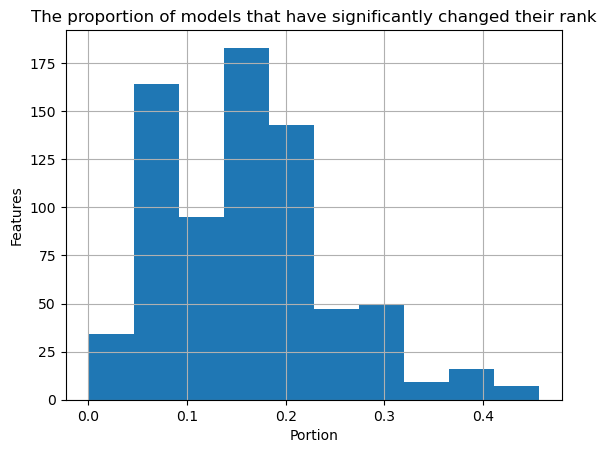

In [25]:
plt.title("The proportion of models that have significantly changed their rank")
plt.xlabel("Portion")
plt.ylabel("Features")
sign["the proportion of significant changes in rankings"].hist(bins=10)

# Core

In [26]:
core_1 = [
    "SemgHandMovementCh2",
    "SemgHandSubjectCh2",
    "SyntheticControl",
    "PigArtPressure",
    "FordA",
    "UWaveGestureLibraryX",
    "Yoga",
    "Crop",
    "UWaveGestureLibraryZ",
    "NonInvasiveFetalECGThorax1",
    "Trace",
    "InsectEPGRegularTrain",
    "GunPointOldVersusYoung",
    "InsectEPGSmallTrain",
    "Phoneme",
    "MixedShapesRegularTrain",
    "ToeSegmentation1",
    "EOGHorizontalSignal",
    "InlineSkate",
    "Plane"
]

core_2 = [
    "ChlorineConcentration",
    "CinCECGTorso",
    "FaceFour",
    "FordA",
    "InlineSkate",
    "NonInvasiveFetalECGThorax1",
    "Plane",
    "SyntheticControl",
    "ToeSegmentation1",
    "Trace",
    "UWaveGestureLibraryX",
    "UWaveGestureLibraryY",
    "UWaveGestureLibraryZ",
    "GunPointOldVersusYoung",
    "InsectEPGRegularTrain",
    "InsectEPGSmallTrain",
    "PigArtPressure",
    "SemgHandMovementCh2",
    "SemgHandSubjectCh2",
    "MixedShapesRegularTrain",
    "EOGHorizontalSignal",
    "Crop"
]

core_3 = [
    "Adiac",
    "UMD",
    "GunPointAgeSpan",
    "ToeSegmentation2",
    "DiatomSizeReduction",
    "DistalPhalanxOutlineAgeGroup",
    "NonInvasiveFetalECGThorax1",
    "WordSynonyms",
    "ProximalPhalanxOutlineAgeGroup",
    "RefrigerationDevices",
    "ShapesAll"
]

core_4 = [
    "ArrowHead",
    "Haptics",
    "PigCVP",
    "Symbols",
    "Coffee",
    "UWaveGestureLibraryAll",
    "EOGVerticalSignal",
    "NonInvasiveFetalECGThorax2",
    "ProximalPhalanxOutlineAgeGroup",
    "FordB",
    "SmallKitchenAppliances"
]

core_5 = [
    "ArrowHead",
    "Beef",
    "BeetleFly",
    "BirdChicken",
    "ChlorineConcentration",
    "CinCECGTorso",
    "CricketY",
    "DiatomSizeReduction",
    "DistalPhalanxOutlineAgeGroup",
    "ECG200",
    "ECGFiveDays",
    "ElectricDevices",
    "FaceAll",
    "FacesUCR",
    "GunPoint",
    "Ham",
    "Haptics",
    "Lightning2",
    "UWaveGestureLibraryAll",
    "SemgHandGenderCh2",
    "Chinatown"
]

core_6 = [
    "ArrowHead",
    "Beef",
    "BeetleFly",
    "Haptics",
    "SyntheticControl",
    "Herring",
    "Lightning2",
    "Trace",
    "CricketY",
    "CricketZ",
    "DiatomSizeReduction",
    "DistalPhalanxOutlineAgeGroup",
    "Earthquakes",
    "ECG5000",
    "ECGFiveDays",
    "ElectricDevices",
    "FaceAll",
    "GunPoint"
]

core = [core_1, core_2, core_3, core_4, core_5, core_6]

data = {}
ranks_all = get_ranks(datasets)
data['Model'] = ranks_all['model']

data['Mean rank all datasets'] = ranks_all[idx].mean(axis=1)

for c,i  in zip(core, range(1, len(core) + 1)):
    ranks_core = get_ranks(c)
    data['Mean rank core {}'.format(i)] = ranks_core[idx].mean(axis=1)
ranks_ = pd.DataFrame(data)
ranks_.to_csv("ranks.csv")

C:\Users\aa\AppData\Local\Temp\ipykernel_16388\1310147258.py:71: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sum_[str(i)][np.argsort(sum_[str(i)])] = np.arange(len(sum_[str(i)])) + 1
C:\Users\aa\AppData\Local\Temp\ipykernel_16388\131014725

In [27]:
ranks_

Model  Mean rank all datasets  Mean rank core 1  Mean rank core 2  \
0       1NN-DTW                1.900000          2.733333          2.433333   
1       Arsenal               25.900000         19.200000         20.366667   
2          BOSS               10.966667          9.033333          8.900000   
3           CIF               19.133333         24.833333         25.300000   
4           CNN                2.933333          2.233333          2.433333   
5       Catch22                5.066667          7.700000          6.233333   
6         DrCIF               26.400000         31.566667         32.333333   
7            EE                8.733333         12.833333         12.333333   
8   FreshPRINCE               20.266667         29.500000         26.966667   
9           HC1               31.333333         32.200000         32.500000   
10          HC2               35.000000         35.000000         35.000000   
11     Hydra-MR               33.833333         33.566667         33.366667   
12        Hydra               26.766667         25.233333         25.800000   
13   InceptionT               27.766667         28.133333         27.900000   
14       Mini-R               29.433333         26.933333         27.266667   
15        MrSQM               20.800000         17.433333         16.033333   
16      Multi-R               33.166667         32.533333         31.800000   
17           PF               15.700000         22.066667         21.466667   
18         RDST               30.866667         27.000000         27.500000   
19         RISE                8.266667          5.666667          6.233333   
20       ROCKET               24.366667         16.066667         18.400000   
21          RSF                4.533333          4.600000          4.366667   
22        RSTSF               21.600000         22.166667         22.566667   
23       ResNet               16.700000         10.966667         11.133333   
24          STC               13.500000         10.533333         10.533333   
25         STSF               15.200000         13.100000         17.033333   
26     ShapeDTW                1.166667          1.066667          1.133333   
27   Signatures                5.400000          5.000000          5.333333   
28          TDE               17.833333         17.400000         17.966667   
29     TS-CHIEF               27.900000         27.266667         28.100000   
30          TSF                7.066667          7.166667          8.233333   
31      TSFresh               10.000000         18.100000         12.966667   
32     WEASEL-D               24.233333         20.733333         19.700000   
33       WEASEL               14.200000         16.133333         16.700000   
34        cBOSS               12.066667         14.300000         13.666667   

    Mean rank core 3  Mean rank core 4  Mean rank core 5  Mean rank core 6  
0           2.766667          1.166667          2.633333          3.433333  
1          26.133333         29.666667         29.000000         31.866667  
2          18.200000         11.633333         13.866667         15.033333  
3          14.333333         19.000000         19.066667         18.266667  
4           3.133333          2.833333          2.766667          2.066667  
5           5.200000          9.433333          1.566667          3.366667  
6          20.333333         24.366667         23.633333         21.933333  
7          10.500000          8.700000          9.900000         10.366667  
8          15.366667         17.533333         18.666667         19.400000  
9          29.600000         28.466667         28.300000         28.166667  
10         33.933333         34.966667         34.733333         34.733333  
11         32.200000         33.133333         32.300000         31.666667  
12         27.500000         26.233333         27.333333         25.300000  
13         26.833333         26.100000         27.766667         28.766667  
14        

In [28]:
for i in [1, 1, 1, 5, 5, 5, 10, 10, 10, 20, 20, 20, 50, 50, 50, 70, 70, 70]:
    core_random = random.sample(datasets, i)
    ranks_core = get_ranks(core_random)
    data['Mean rank random core of size {}'.format(i)] = ranks_core[idx].mean(axis=1)

    


C:\Users\aa\AppData\Local\Temp\ipykernel_16388\1310147258.py:71: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sum_[str(i)][np.argsort(sum_[str(i)])] = np.arange(len(sum_[str(i)])) + 1
C:\Users\aa\AppData\Local\Temp\ipykernel_16388\131014725

In [29]:
mae = []
for column in ranks_.columns[1:]:
    mae.append(np.mean(np.abs(ranks_[column] - ranks_["Mean rank all datasets"])))
    

In [30]:
pd.DataFrame({'core':ranks_.columns[1:],  'MAE' : mae})

core       MAE
0  Mean rank all datasets  0.000000
1        Mean rank core 1  2.758095
2        Mean rank core 2  2.430476
3        Mean rank core 3  2.243810
4        Mean rank core 4  1.550476
5        Mean rank core 5  1.923810
6        Mean rank core 6  2.040000

In [31]:
ranks_core[idx].mean(axis=1)
data = {
    'Model': ranks_core['model'],
    'Mean rank': ranks_core[idx].mean(axis=1),
}
pd.DataFrame(data)

Model  Mean rank
0       1NN-DTW   1.133333
1       Arsenal  25.066667
2          BOSS  11.066667
3           CIF  19.566667
4           CNN   3.000000
5       Catch22   5.366667
6         DrCIF  27.700000
7            EE   8.233333
8   FreshPRINCE  20.133333
9           HC1  30.733333
10          HC2  34.966667
11     Hydra-MR  33.666667
12        Hydra  29.366667
13   InceptionT  26.833333
14       Mini-R  30.366667
15        MrSQM  20.533333
16      Multi-R  33.366667
17           PF  13.633333
18         RDST  30.133333
19         RISE   9.600000
20       ROCKET  23.633333
21          RSF   4.633333
22        RSTSF  21.866667
23       ResNet  17.366667
24          STC  14.066667
25         STSF  16.600000
26     ShapeDTW   1.866667
27   Signatures   5.000000
28          TDE  16.233333
29     TS-CHIEF  25.066667
30          TSF   7.033333
31      TSFresh   9.200000
32     WEASEL-D  25.700000
33       WEASEL  15.300000
34        cBOSS  11.966667